In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
import re 

In [2]:
all = pd.read_csv('Production_Crops_Livestock_E_All_Data_Normalized_2.csv')
all.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,ha,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,ha,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,ha,6000.0,F


In [3]:
# Area contains all countries first, sorted alphabetically, then further areas that will need to be deleted for further country-based analysis
# define cutoff index
cutoff = max(all.index[all.Area == 'Zimbabwe'].to_list())
# drop all rows whose index is bigger than the cutoff
all.drop(all[all.index > cutoff].index, inplace = True)

In [4]:
# dataset contains total for China and separate values for mainland, Hong Kong etc. -> drop China total
all.drop(all[all.Area == 'China'].index, inplace=True)

In [5]:
# some item categories contain totals of subcategories -> drop totals
all = all[~all.Item.str.contains(', Total')]

In [6]:
# consider categories with 'Primary' to be grouping other subcategories -> drop them
all = all[~all.Item.str.contains('Primary')]

In [7]:
# Coir has a correlation of 1 with everything else (only 0 values in 2020). -> drop coir
all.drop(all[all.Item == 'Coir'].index, inplace=True)

In [8]:
# create pivot table: area harvested for each country (rows) - item (columns) combination; drop 'Y2020' column index
all_pivot = all[all.Element == 'Area harvested'][all.Year == 2020][['Area', 'Item', 'Value']].reset_index(drop=True).set_index('Area').pivot(columns=['Item'])
all_pivot.columns = all_pivot.columns.droplevel(0)

C:\Users\1\AppData\Local\Temp\ipykernel_20792\586532870.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_pivot = all[all.Element == 'Area harvested'][all.Year == 2020][['Area', 'Item', 'Value']].reset_index(drop=True).set_index('Area').pivot(columns=['Item'])


In [9]:
# replace null values with 0
all_pivot = all_pivot.fillna('0')

In [10]:
# convert datatypes into numeric
all_pivot = all_pivot.apply(pd.to_numeric)

In [11]:
all_pivot.dtypes

Item
Agave fibres nes                    float64
Almonds, with shell                 float64
Anise, badian, fennel, coriander    float64
Apples                              float64
Apricots                            float64
                                     ...   
Walnuts, with shell                 float64
Watermelons                         float64
Wheat                               float64
Yams                                float64
Yautia (cocoyam)                    float64
Length: 160, dtype: object

In [12]:
# create new column with total area
all_pivot['Total Area'] = all_pivot.sum(axis=1)

In [13]:
# all of the countries have area > 0
all_pivot['Total Area'].sort_values().head()

Area
Faroe Islands        104.0
China, Macao SAR     128.0
Nauru                426.0
Tokelau              535.0
Malta               1020.0
Name: Total Area, dtype: float64

In [14]:
# create list with crops
columns_list = all_pivot.columns.drop('Total Area')

In [15]:
# calculate percentage of harvested area per crop
for i in columns_list:
    all_pivot[i] = all_pivot[i]/all_pivot['Total Area']

In [16]:
# drop total area
all_pivot = all_pivot.drop('Total Area', axis=1)

In [17]:
# check whether the dataset looks nice
all_pivot

Item,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,...,Tung nuts,Vanilla,"Vegetables, fresh nes","Vegetables, leguminous nes",Vetches,"Walnuts, with shell",Watermelons,Wheat,Yams,Yautia (cocoyam)
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.005721,0.006658,0.006628,0.004518,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.043346,0.000000,0.000000,0.001346,0.017123,0.689617,0.000000,0.000000
Albania,0.0,0.000000,0.000000,0.015160,0.001187,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.005659,0.000075,0.022246,0.000000,0.018703,0.185027,0.000000,0.000000
Algeria,0.0,0.007684,0.000000,0.007347,0.006611,0.0,0.001297,0.000000,0.000000,0.000000,...,0.0,0.000000,0.012626,0.007369,0.000034,0.000000,0.013570,0.411129,0.000000,0.000000
Angola,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.010585,0.000000,0.000000,0.000000,0.000000,0.000570,0.000000,0.000000
Antigua and Barbuda,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.045535,0.000000,0.000000,0.000000,0.004421,0.000000,0.018568,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.008039,0.000000,...,0.0,0.000000,0.004381,0.000000,0.000000,0.000000,0.005008,0.000156,0.003209,0.005228
Viet Nam,0.0,0.000000,0.000494,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.063182,0.000000,0.000000,0.000000,0.004562,0.000000,0.000000,0.000000
Yemen,0.0,0.007449,0.000000,0.002627,0.000749,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.003195,0.000000,0.000000,0.000000,0.011288,0.066473,0.000000,0.000000


Quick correlation analysis just out of curiosity

In [18]:
# define correlation matrix
matrix = all_pivot.corr()

In [19]:
# plot heatmap based on correlation matrix
# matrix_sig = matrix[abs(matrix) >= 0.8]
# mask = np.triu(np.ones_like(matrix_sig, dtype=bool))
# ax, fig = plt.subplots(figsize=(12,8))
# sns.heatmap(matrix_sig, vmin=-1, vmax=1, cmap='vlag', mask=mask)
# plt.show()

In [20]:
# want to get the columns with the most significant correlations
# replace 1.0 correlations with 0 so we can get the "real" max values
matrix_replace_1 = matrix.replace(1.0, 0)
max_corr = []
min_corr = []
mean_corr = []
for c in matrix.columns:
    max_corr.append(matrix_replace_1[c].max())
    min_corr.append(matrix_replace_1[c].min())
    mean_corr.append(matrix_replace_1[c].mean())
corr_analysis = pd.DataFrame({'item': matrix.columns, 'max': max_corr, 'mean': mean_corr, 'min': min_corr})

In [21]:
# plot the distribution of the max values -> some are really high
# sns.scatterplot(data=corr_analysis, x=corr_analysis.item, y='max')
# plt.show

In [22]:
# plot the distribution of the min values
# sns.scatterplot(data=corr_analysis, x=corr_analysis.item, y='min')
# plt.show

In [23]:
# get list of crops with at least one correlation > 0.7
corr_high = []
for c in matrix.columns:
    if matrix_replace_1[c].max() > 0.7:
        corr_high.append(c)

In [24]:
# plot heatmap of those crops that have at least one correlation > 0.7
# all_pivot_sig = all_pivot[corr_high]
# matrix_sig2 = all_pivot_sig.corr()
# mask = np.triu(np.ones_like(matrix_sig2, dtype=bool))
# ax, fig = plt.subplots(figsize=(16,8))
# sns.heatmap(matrix_sig2, vmin=-1, vmax=1, cmap='vlag', mask=mask)
# plt.show()

In [25]:
# no significant negative correlations
corr_low = []
for c in matrix.columns:
    if matrix_replace_1[c].min() < -0.5:
        corr_low.append(c)
corr_low

[]

In [26]:
# calculate the inertia of kmeans within range of 1-50 clusters each
inertia_list = []
for i in range(1,50):
    myKMeans = KMeans(n_clusters=i)
    myKMeans.fit(all_pivot)
    inertia_list.append(round(myKMeans.inertia_))
n_list = []
for i in range(1,50):
    n_list.append(i)
inertia_df = pd.DataFrame({'n': n_list, 'inertia': inertia_list})

c:\Users\1\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


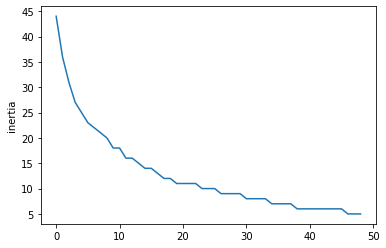

In [27]:
# plot evolution of inertia depending on the number of clusters
sns.lineplot(data=inertia_df.inertia)
plt.show()

In [28]:
# decided to go for 20 clusters -> fit the data, and calculate the clusters
number_of_clusters = 20
my_kmeans = KMeans(n_clusters= number_of_clusters, random_state=24)
my_kmeans.fit(all_pivot)
clusters = my_kmeans.predict(all_pivot)

In [29]:
# store the number of the cluster each country belongs to in a new column
all_pivot["cluster"] = clusters
# get inertia
my_kmeans.inertia_

11.425516717673627

In [30]:
# have a look at the countries within a certain cluster
all_pivot[all_pivot.cluster == 18]

Item,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,...,Vanilla,"Vegetables, fresh nes","Vegetables, leguminous nes",Vetches,"Walnuts, with shell",Watermelons,Wheat,Yams,Yautia (cocoyam),cluster
Area,,,,,,,,,,,,,,,,,,,,,
Namibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.005274,0.0,0.0,0.0,0.000499,0.003188,0.0,0.0,18


In [31]:
# check the size of each cluster
all_pivot.reset_index().groupby('cluster').agg({'Area': 'count'})

Item,Area
cluster,
0,23
1,8
2,28
3,15
4,6
5,16
6,8
7,6
8,2


In [32]:
cluster_for_visualization = all_pivot['cluster']

In [33]:
# TO CSV
clustering = cluster_for_visualization.to_csv('clustering.csv')

In [34]:
# group the clusters to check for similarity between the clusters
all_cluster = all_pivot.groupby('cluster').mean()

Quick differences analysis

In [35]:
cluster_differences_euclid = pd.DataFrame(pairwise_distances(all_cluster))

In [36]:
# sns.heatmap(cluster_differences_euclid)
# plt.title('cluster euclid')
# plt.show()

In [37]:
cluster_differences_manhattan = pd.DataFrame(pairwise_distances(all_cluster, metric='manhattan'))

In [38]:
# sns.heatmap(cluster_differences_manhattan)
# plt.title('cluster manhattan')
# plt.show()

Silhouette score

In [39]:
labels = my_kmeans.labels_
len(labels)

199

In [40]:
silhouette_score(all_pivot, labels, metric='euclidean')

0.7146605623963846

In [41]:
silhouette_score(all_pivot, labels, metric='manhattan')

0.6247381267233192

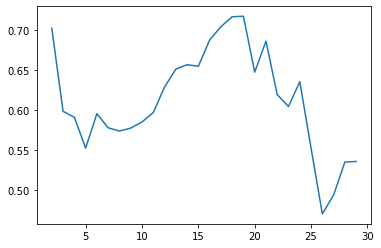

In [42]:
max_k = 30
sil_score = []

for k in range(2, max_k): 
    labels = KMeans(n_clusters=k).fit(all_pivot).labels_
    sil_score.append(silhouette_score(all_pivot, labels))

sns.lineplot(x=range(2, max_k), y=sil_score)
plt.show()

In [43]:
all_pivot

Item,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,...,Vanilla,"Vegetables, fresh nes","Vegetables, leguminous nes",Vetches,"Walnuts, with shell",Watermelons,Wheat,Yams,Yautia (cocoyam),cluster
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.005721,0.006658,0.006628,0.004518,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.043346,0.000000,0.000000,0.001346,0.017123,0.689617,0.000000,0.000000,2
Albania,0.0,0.000000,0.000000,0.015160,0.001187,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005659,0.000075,0.022246,0.000000,0.018703,0.185027,0.000000,0.000000,0
Algeria,0.0,0.007684,0.000000,0.007347,0.006611,0.0,0.001297,0.000000,0.000000,0.000000,...,0.000000,0.012626,0.007369,0.000034,0.000000,0.013570,0.411129,0.000000,0.000000,2
Angola,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010585,0.000000,0.000000,0.000000,0.000000,0.000570,0.000000,0.000000,13
Antigua and Barbuda,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.045535,0.000000,0.000000,0.000000,0.004421,0.000000,0.018568,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.008039,0.000000,...,0.000000,0.004381,0.000000,0.000000,0.000000,0.005008,0.000156,0.003209,0.005228,13
Viet Nam,0.0,0.000000,0.000494,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.063182,0.000000,0.000000,0.000000,0.004562,0.000000,0.000000,0.000000,3
Yemen,0.0,0.007449,0.000000,0.002627,0.000749,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003195,0.000000,0.000000,0.000000,0.011288,0.066473,0.000000,0.000000,4


In [44]:
silhouette_samples = silhouette_samples(all_pivot, labels, metric='euclidean')
all_pivot['silhouette_samples'] = silhouette_samples

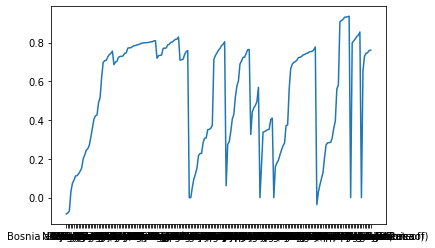

In [45]:
# some scores are really high, and some clusters seem to be dense, but there are some low values as well
sil_scores = all_pivot[['cluster', 'silhouette_samples']].sort_values(['cluster', 'silhouette_samples'])
plt.plot(sil_scores['silhouette_samples'])
plt.show()

In [46]:
# checking for countries with a negative silhouette score
sil_scores.query('silhouette_samples < 0')

Item,cluster,silhouette_samples
Area,,
Austria,0,-0.083982
Bosnia and Herzegovina,0,-0.079424
Slovenia,0,-0.068302
United Republic of Tanzania,14,-0.036012


In [47]:
# creating an overview of all clusters with their id, mean silhouette score and number of countries per cluster
sil_scores_grouped = sil_scores.groupby('cluster')['silhouette_samples'].agg(['mean', 'count']).sort_values(by='mean', ascending=False).reset_index()

In [48]:
# overview of all clusters with their id, mean silhouette score, number of countries per cluster and cluster 2 id before cutoff
sil_scores_grouped['cluster2'] = sil_scores_grouped.index
sil_scores_grouped

,cluster,mean,count,cluster2
0,15,0.924815,7,0
1,17,0.825376,6,1
2,3,0.779707,15,2
3,2,0.769991,28,3
4,6,0.762989,8,4
5,19,0.733140,6,5
6,4,0.731228,6,6
7,13,0.720260,18,7
8,9,0.714923,8,8
9,1,0.712421,8,9


In [98]:
# TO CVS
sil_scores_grouped_csv = sil_scores_grouped.to_csv('sil_scores_grouped.csv')

In [49]:
# determining the lowest value of the silhouette scores' means that is above 0.5 = min_mean_large
mean_large = []
for v in sil_scores_grouped['mean']:
    if v >= 0.5:
        mean_large.append(v)
min_mean_large = min(mean_large)
min_mean_large

0.5483981926775707

In [50]:
# calculating the cluster id to be attributed to all not so dense clusters = cluster2 id of the cluster with min_mean_large as per above + 1
cluster2_cutoff = sil_scores_grouped[sil_scores_grouped['mean'] == min_mean_large]['cluster2'].item() + 1
cluster2_cutoff

11

In [51]:
# number clusters in cluster 2 according to their mean silhouette score: starting from 0 with the most dense cluster etc. Set cluster2 to the cutoff value for all not dense clusters
for r in range(len(sil_scores_grouped)):
    if sil_scores_grouped.loc[r,'mean'] < min_mean_large:
        sil_scores_grouped.loc[r, 'cluster2'] = cluster2_cutoff

In [52]:
# overview of all clusters with their id, mean silhouette score, number of countries per cluster and cluster 2 id
sil_scores_grouped

,cluster,mean,count,cluster2
0,15,0.924815,7,0
1,17,0.825376,6,1
2,3,0.779707,15,2
3,2,0.769991,28,3
4,6,0.762989,8,4
5,19,0.733140,6,5
6,4,0.731228,6,6
7,13,0.720260,18,7
8,9,0.714923,8,8
9,1,0.712421,8,9


In [53]:
# create a lookup file with all clusters to be re-clustered and their cluster-cutoff id
cluster_lookup = sil_scores_grouped[['cluster', 'cluster2']][sil_scores_grouped['cluster2'] == cluster2_cutoff]

In [54]:
# create new column 'cluster2' and set it equal to 'cluster
all_pivot['cluster2'] = all_pivot['cluster']
all_pivot = all_pivot.reset_index()

In [55]:
# set value of cluster2 equal to the one defined in sil_scores_grouped, i.e. clusters 0-cutoff for all dense clusters, and cutoff+1 for all others
for i in range(len(all_pivot)):
    cluster = all_pivot.loc[i, 'cluster2']
    cluster2 = sil_scores_grouped[sil_scores_grouped['cluster'] == cluster]['cluster2'].item()
    all_pivot.loc[i, 'cluster2'] = cluster2

In [56]:
all_pivot = all_pivot.set_index('Area')

In [57]:
# check implementation for single cluster ids
all_pivot[all_pivot['cluster2'] == 11]

Item,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,...,"Vegetables, leguminous nes",Vetches,"Walnuts, with shell",Watermelons,Wheat,Yams,Yautia (cocoyam),cluster,silhouette_samples,cluster2
Area,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.00000,0.000000,0.015160,0.001187,0.0,0.0,0.000000,0.000000,0.0,...,0.000075,0.022246,0.000000,0.018703,0.185027,0.000000,0.000000,0,0.030271,11
Antigua and Barbuda,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.004421,0.000000,0.018568,0.000000,5,0.000000,11
Austria,0.0,0.00000,0.000000,0.005982,0.000772,0.0,0.0,0.000688,0.000000,0.0,...,0.000251,0.000000,0.000167,0.000037,0.259566,0.000000,0.000000,0,-0.083982,11
Bahamas,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.011076,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,0.338194,11
Bahrain,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.001025,0.000000,0.000000,0.000000,10,0.325932,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trinidad and Tobago,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.003257,0.0,...,0.000000,0.000000,0.000000,0.003594,0.000000,0.000112,0.005364,5,0.228342,11
Uganda,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.002155,0.000000,0.000000,5,0.227738,11
Ukraine,0.0,0.00000,0.000101,0.003195,0.000274,0.0,0.0,0.000000,0.000000,0.0,...,0.000002,0.000109,0.000504,0.001748,0.246712,0.000000,0.000000,0,0.405741,11


In [58]:
# create a pivot table which only includes the countries to be re-clustered
all_pivot2 = all_pivot[all_pivot['cluster2'] == cluster2_cutoff].drop(['cluster', 'silhouette_samples', 'cluster2'], axis=1)

In [59]:
# drop all crops columns which contain only 0
for c in all_pivot2.columns:
    if sum(all_pivot2[c]) == 0:
        all_pivot2 = all_pivot2.drop(c, axis=1)

In [60]:
all_pivot2

Item,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,...,Tung nuts,Vanilla,"Vegetables, fresh nes","Vegetables, leguminous nes",Vetches,"Walnuts, with shell",Watermelons,Wheat,Yams,Yautia (cocoyam)
Area,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.00000,0.000000,0.015160,0.001187,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.005659,0.000075,0.022246,0.000000,0.018703,0.185027,0.000000,0.000000
Antigua and Barbuda,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.045535,0.000000,0.000000,0.000000,0.004421,0.000000,0.018568,0.000000
Austria,0.0,0.00000,0.000000,0.005982,0.000772,0.0,0.0,0.000688,0.000000,0.0,...,0.0,0.000000,0.000735,0.000251,0.000000,0.000167,0.000037,0.259566,0.000000,0.000000
Bahamas,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.011076,0.0,...,0.0,0.000000,0.309195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bahrain,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.006407,0.000000,0.000000,0.000000,0.001025,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trinidad and Tobago,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.003257,0.0,...,0.0,0.000000,0.004858,0.000000,0.000000,0.000000,0.003594,0.000000,0.000112,0.005364
Uganda,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000048,0.020231,0.000000,0.000000,0.000000,0.000000,0.002155,0.000000,0.000000
Ukraine,0.0,0.00000,0.000101,0.003195,0.000274,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.001684,0.000002,0.000109,0.000504,0.001748,0.246712,0.000000,0.000000


Re-cluster the not so dense K-means clusters using hierarchical clustering because of the rather small dataset

In [61]:
# Ward: minimizes the variance of the clusters being merged
clustering_ward = AgglomerativeClustering(n_clusters=12, linkage='ward', compute_distances=True).fit(all_pivot2)
labels_ward = clustering_ward.labels_
all_pivot2['Ward'] = labels_ward

In [62]:
# Average: uses the average of the distances of each observation of the two sets
clustering_av = AgglomerativeClustering(n_clusters=12, linkage='average').fit(all_pivot2)
labels_av = clustering_av.labels_
all_pivot2['Av'] = labels_av

In [63]:
# Complete or maximum linkag: uses the maximum distances between all observations of the two sets
clustering_comp = AgglomerativeClustering(n_clusters=12, linkage='complete').fit(all_pivot2)
labels_comp = clustering_comp.labels_
all_pivot2['Comp'] = labels_comp

In [64]:
# Single uses the minimum of the distances between all observations of the two sets
clustering_single = AgglomerativeClustering(n_clusters=12, linkage='single').fit(all_pivot2)
labels_single = clustering_single.labels_
all_pivot2['Single'] = labels_single

In [65]:
# manually check each cluster -> they are the same regardless of the algorithm used!
all_pivot2[all_pivot2['Ward']==2]

Item,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,...,Vetches,"Walnuts, with shell",Watermelons,Wheat,Yams,Yautia (cocoyam),Ward,Av,Comp,Single
Area,,,,,,,,,,,,,,,,,,,,,
Antigua and Barbuda,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.004421,0.0,0.018568,0.000000,2,1,0,1
Costa Rica,0.0,0.0,0.0,0.000000,0.0,0.0,0.000013,0.00007,0.007363,0.0,...,0.0,0.0,0.003986,0.0,0.001977,0.001342,2,1,0,1
Grenada,0.0,0.0,0.0,0.011020,0.0,0.0,0.000000,0.00000,0.028757,0.0,...,0.0,0.0,0.015113,0.0,0.000000,0.000000,2,1,0,1
Jamaica,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.003498,0.0,...,0.0,0.0,0.006367,0.0,0.089476,0.000000,2,1,0,1
Papua New Guinea,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.019199,0.000000,2,1,0,1
Puerto Rico,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.011289,0.0,...,0.0,0.0,0.012403,0.0,0.008758,0.007543,2,1,0,1
Saint Vincent and the Grenadines,0.0,0.0,0.0,0.005719,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.013257,0.000000,2,1,0,1
Trinidad and Tobago,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.003257,0.0,...,0.0,0.0,0.003594,0.0,0.000112,0.005364,2,1,0,1


In [66]:
# get one dataset of reclustered countries with cluster2 ids larger than the ones of the dense clusters
all_pivot2['cluster2'] = all_pivot2['Ward'].apply(lambda x: x+cluster2_cutoff)
all_pivot2 = all_pivot2.reset_index()

In [67]:
for i in all_pivot.index:
    if i in all_pivot2['Area'].to_list():
        all_pivot['cluster2'][i] = all_pivot2[all_pivot2['Area'] == i]['cluster2'].item()

C:\Users\1\AppData\Local\Temp\ipykernel_20792\3648789452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pivot['cluster2'][i] = all_pivot2[all_pivot2['Area'] == i]['cluster2'].item()


In [68]:
all_pivot2[all_pivot2['cluster2'] == 11]

Item,Area,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,...,"Walnuts, with shell",Watermelons,Wheat,Yams,Yautia (cocoyam),Ward,Av,Comp,Single,cluster2
10,Brunei Darussalam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.001346,0.000000,0.000000,0.0,0,0,1,0,11
16,"China, Hong Kong SAR",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0,11
28,Djibouti,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0,11
53,Maldives,0.0,0.0,0.0,0.0,0.0,0.003108,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0,11
59,New Caledonia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.004710,0.004037,0.109516,0.0,0,0,1,0,11
78,Singapore,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0,11
81,Tonga,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.003149,0.000000,0.018735,0.0,0,0,1,0,11


In [69]:
all_pivot_csv = all_pivot.reset_index()[['Area', 'cluster2']]

In [70]:
# export countries + clusters
re_clustering = all_pivot.to_csv('re_clustering.csv')

Apply Decision Tree to get main drivers of each cluster

In [71]:
X = all_pivot.drop(['cluster', 'silhouette_samples', 'cluster2'], axis=1)
y_all = all_pivot['cluster2'].reset_index(drop=True)

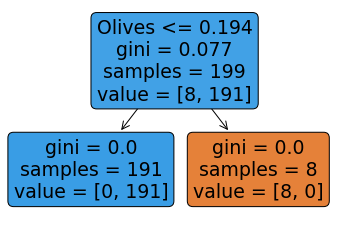

In [72]:
# loop over all clusters (attention: at this stage manually insofar as the cluster id needs to be provided in the equation "if y_all[i] == 0:", cluster id in this case equal to 0)
# for each cluster id equal to the one provided: set element in y = 0, all others to 1 to check main driver of difference between this cluster and all others
y = []
for i in range(len(y_all)):
    if y_all[i] == 4:
        y.append(0)
    else:
        y.append(1)

clf = DecisionTreeClassifier(max_depth=2, min_samples_split=3, random_state=10)
clf = clf.fit(X, y)

col_names=X.columns.to_list()
plt.figure(figsize=(6, 4))
plot_tree(clf, filled=True, rounded=True, feature_names=col_names)
plt.show()

In [73]:
cluster2_list = pd.Series(all_pivot['cluster2'].unique()).sort_values().to_list()

In [74]:
# loop over all cluster2 ids, get y binary for each of the cluster2 ids, get decision trees and extract the text for each cluster2 id. Append the text to a list.
r = []
for c in cluster2_list:
    y = []
    for i in range(len(y_all)):
        if y_all[i] == c:
            y.append(0)
        else:
            y.append(1)
    #print(len(y))
    clf = DecisionTreeClassifier(max_depth=2, min_samples_split=3, random_state=10)
    clf = clf.fit(X, y)
    r.append(export_text(clf, feature_names=col_names, show_weights=True))

rr = pd.Series(r)

In [75]:
rr_split = rr.str.split("|", n=22, expand=True)
rr_split = rr_split.fillna('   ')

In [76]:
# get list of columns with only one unique value
unikwe_list = []
for c in rr_split.columns:
    unikwe_list.append(rr_split[c].nunique())
unikwe_list = pd.Series(unikwe_list)
unikwe = pd.DataFrame(unikwe_list)
not_unikwe = unikwe[unikwe[0] > 1].reset_index()['index']

In [77]:
# keep only the columns with at least two unique values
rr_split = rr_split.filter(not_unikwe)
rr_split = rr_split.replace(to_replace='--- ', value='', regex=True).reset_index()
rr_split = pd.DataFrame(rr_split)

In [78]:
# set column names
columns_list = ['cluster_id']
for i in range(rr_split.shape[1]-1):
    columns_list.append(i)
columns_list

rr_split.columns = columns_list

In [79]:
# select clusters that can be identified based on one crop only
single_crop_clusters = rr_split[rr_split[1].str.startswith('weights')][rr_split[3].str.startswith('weights')].reset_index(drop=True)
single_crop_clusters = single_crop_clusters[['cluster_id', 2]].replace(to_replace='\n', value='', regex=True).set_index('cluster_id')

C:\Users\1\AppData\Local\Temp\ipykernel_20792\1180395228.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_crop_clusters = rr_split[rr_split[1].str.startswith('weights')][rr_split[3].str.startswith('weights')].reset_index(drop=True)


In [80]:
check = []
for i in range(len(all_pivot_csv)):
    if all_pivot_csv.loc[i, 'cluster2'] in single_crop_clusters.index:
        check.append(1)
    else:
        check.append(0)
check_series = pd.Series(check)

In [81]:
all_pivot_check = pd.concat([all_pivot_csv, check_series], axis=1)
all_pivot_check_grouped = all_pivot_check.groupby('cluster2')[0].agg('sum').reset_index()
all_pivot_check_grouped = all_pivot_check_grouped[all_pivot_check_grouped[0] > 0][0]

single_crop_clusters_count = pd.concat([single_crop_clusters, all_pivot_check_grouped], axis=1).reset_index()
single_crop_clusters_count.columns = ['cluster_id', 'crop', 'countries_count']
single_crop_clusters_count

,cluster_id,crop,countries_count
0,0,Coconuts > 0.74,7
1,1,Soybeans > 0.23,6
2,2,"Rice, paddy > 0.36",15
3,4,Olives > 0.19,8
4,6,Sorghum > 0.27,6
5,8,Barley > 0.28,8
6,10,Potatoes > 0.43,2
7,14,Dates > 0.16,6
8,17,"Cocoa, beans > 0.29",3
9,18,Millet > 0.58,1


In [82]:
# the number of countries that can be clustered using 1 crop and 1 threshold only!
all_pivot_sum = all_pivot_check[0].sum()
all_pivot_sum

71

In [83]:
# TO CSV
single_crop_clusters_count_csv = single_crop_clusters_count.to_csv('single_crop_clusters_count.csv')

In [84]:
multi_crop_clusters = pd.concat([rr_split[~rr_split[1].str.startswith('weights')], rr_split[~rr_split[3].str.startswith('weights')]]).reset_index(drop=True)
multi_crop_clusters

,cluster_id,0,1,2,3,4,5,6,7,8,9,10,11
0,3,Wheat <= 0.31\n,Peaches and nectarines <= 0.02\n,,"weights: [0.00, 169.00] class: 1\n",Peaches and nectarines > 0.02\n,,"weights: [1.00, 0.00] class: 0\n",Wheat > 0.31\n,Barley <= 0.30\n,"weights: [27.00, 1.00] class: 0\n",Barley > 0.30\n,"weights: [0.00, 1.00] class: 1\n"
1,12,"Rice, paddy <= 0.12\n",Artichokes <= 0.00\n,,"weights: [0.00, 163.00] class: 1\n",Artichokes > 0.00\n,,"weights: [1.00, 1.00] class: 0\n","Rice, paddy > 0.12\n","Rice, paddy <= 0.36\n","weights: [16.00, 3.00] class: 0\n","Rice, paddy > 0.36\n","weights: [0.00, 15.00] class: 1\n"
2,13,Bananas <= 0.08\n,"Fruit, citrus nes <= 0.02\n",,"weights: [2.00, 189.00] class: 1\n","Fruit, citrus nes > 0.02\n",,"weights: [2.00, 1.00] class: 0\n",Bananas > 0.08\n,Yautia (cocoyam) <= 0.02\n,"weights: [4.00, 0.00] class: 0\n",Yautia (cocoyam) > 0.02\n,"weights: [0.00, 1.00] class: 1\n"
3,15,Cassava <= 0.13\n,Kola nuts <= 0.01\n,,"weights: [4.00, 183.00] class: 1\n",Kola nuts > 0.01\n,,"weights: [2.00, 1.00] class: 0\n",Cassava > 0.13\n,Maize <= 0.29\n,"weights: [8.00, 0.00] class: 0\n",Maize > 0.29\n,"weights: [0.00, 1.00] class: 1\n"
4,16,Apples <= 0.01\n,Artichokes <= 0.00\n,,"weights: [0.00, 173.00] class: 1\n",Artichokes > 0.00\n,,"weights: [2.00, 1.00] class: 0\n",Apples > 0.01\n,Maize <= 0.03\n,"weights: [0.00, 7.00] class: 1\n",Maize > 0.03\n,"weights: [10.00, 6.00] class: 0\n"
5,19,Sunflower seed <= 0.14\n,Plums and sloes <= 0.03\n,,"weights: [3.00, 189.00] class: 1\n",Plums and sloes > 0.03\n,,"weights: [2.00, 0.00] class: 0\n",Sunflower seed > 0.14\n,"weights: [5.00, 0.00] class: 0\n",,,
6,5,Millet <= 0.14\n,"weights: [0.00, 192.00] class: 1\n",Millet > 0.14\n,Cassava <= 0.00\n,,"weights: [0.00, 1.00] class: 1\n",Cassava > 0.00\n,,"weights: [6.00, 0.00] class: 0\n",,,
7,7,Maize <= 0.28\n,"weights: [0.00, 175.00] class: 1\n",Maize > 0.28\n,Wheat <= 0.10\n,,"weights: [18.00, 1.00] class: 0\n",Wheat > 0.10\n,,"weights: [0.00, 5.00] class: 1\n",,,
8,9,Coconuts <= 0.30\n,"weights: [0.00, 184.00] class: 1\n",Coconuts > 0.30\n,Coconuts <= 0.74\n,,"weights: [8.00, 0.00] class: 0\n",Coconuts > 0.74\n,,"weights: [0.00, 7.00] class: 1\n",,,
9,11,"Vegetables, fresh nes <= 0.24\n","weights: [0.00, 190.00] class: 1\n","Vegetables, fresh nes > 0.24\n",Tomatoes <= 0.01\n,,"weights: [7.00, 0.00] class: 0\n",Tomatoes > 0.01\n,,"weights: [0.00, 2.00] class: 1\n",,,


In [85]:
dual_crop_clusters = multi_crop_clusters[multi_crop_clusters[5].str.startswith('weights')][multi_crop_clusters[8].str.startswith('weights')]
dual_crop_clusters = dual_crop_clusters[['cluster_id', 0, 1, 2, 3, 4, 5, 6, 7, 8]].replace(to_replace='\n', value='', regex=True).reset_index(drop=True)
dual_crop_clusters

C:\Users\1\AppData\Local\Temp\ipykernel_20792\30468177.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dual_crop_clusters = multi_crop_clusters[multi_crop_clusters[5].str.startswith('weights')][multi_crop_clusters[8].str.startswith('weights')]


,cluster_id,0,1,2,3,4,5,6,7,8
0,5,Millet <= 0.14,"weights: [0.00, 192.00] class: 1",Millet > 0.14,Cassava <= 0.00,,"weights: [0.00, 1.00] class: 1",Cassava > 0.00,,"weights: [6.00, 0.00] class: 0"
1,7,Maize <= 0.28,"weights: [0.00, 175.00] class: 1",Maize > 0.28,Wheat <= 0.10,,"weights: [18.00, 1.00] class: 0",Wheat > 0.10,,"weights: [0.00, 5.00] class: 1"
2,9,Coconuts <= 0.30,"weights: [0.00, 184.00] class: 1",Coconuts > 0.30,Coconuts <= 0.74,,"weights: [8.00, 0.00] class: 0",Coconuts > 0.74,,"weights: [0.00, 7.00] class: 1"
3,11,"Vegetables, fresh nes <= 0.24","weights: [0.00, 190.00] class: 1","Vegetables, fresh nes > 0.24",Tomatoes <= 0.01,,"weights: [7.00, 0.00] class: 0",Tomatoes > 0.01,,"weights: [0.00, 2.00] class: 1"


In [86]:
crop_1 = []
for i in range(len(dual_crop_clusters)):
    if 'class: 1' in dual_crop_clusters.iloc[i, 2]:
        crop_1.append(dual_crop_clusters.iloc[i, 3])
    else:
        crop_1.append(dual_crop_clusters.iloc[i, 1])
crop_1 = pd.Series(crop_1)

In [87]:
crop_2 = []
for i in range(len(dual_crop_clusters)):
    if 'class: 1' in dual_crop_clusters.iloc[i, 6]:
        crop_2.append(dual_crop_clusters.iloc[i, 7])
    else:
        crop_2.append(dual_crop_clusters.iloc[i, 4])
crop_2 = pd.Series(crop_2)

In [88]:
dual_crops = pd.concat([dual_crop_clusters['cluster_id'], crop_1, crop_2], axis=1)
dual_crops.columns = ['cluster_id', 'crop_1', 'crop_2']
dual_crops

,cluster_id,crop_1,crop_2
0,5,Millet > 0.14,Cassava > 0.00
1,7,Maize > 0.28,Wheat <= 0.10
2,9,Coconuts > 0.30,Coconuts <= 0.74
3,11,"Vegetables, fresh nes > 0.24",Tomatoes <= 0.01


In [89]:
check_dual = []
for i in range(len(all_pivot_csv)):
    if all_pivot_csv.loc[i, 'cluster2'] in dual_crop_clusters['cluster_id']:
        check_dual.append(1)
    else:
        check_dual.append(0)
check_dual_series = pd.Series(check_dual)

In [90]:
all_pivot_check_dual = pd.concat([all_pivot_csv, check_dual_series], axis=1)
all_pivot_check_dual_grouped = all_pivot_check_dual.groupby('cluster2')[0].agg('sum').reset_index()
all_pivot_check_dual_grouped = all_pivot_check_dual_grouped[all_pivot_check_dual_grouped[0] > 0][0]

dual_crop_clusters_count = pd.concat([dual_crops, all_pivot_check_dual_grouped], axis=1)
dual_crop_clusters_count.columns = ['cluster_id', 'crop_1', 'crop_2', 'countries_count']
dual_crop_clusters_count

,cluster_id,crop_1,crop_2,countries_count
0,5,Millet > 0.14,Cassava > 0.00,7
1,7,Maize > 0.28,Wheat <= 0.10,6
2,9,Coconuts > 0.30,Coconuts <= 0.74,15
3,11,"Vegetables, fresh nes > 0.24",Tomatoes <= 0.01,28


In [91]:
# the number of clusters that need max 2 crops and max 2 thresholds only
dual_crop_clusters_count_sum = dual_crop_clusters_count['cluster_id'].count() + single_crop_clusters_count['cluster_id'].count()
dual_crop_clusters_count_sum

17

In [92]:
# the number of countries that can be clustered using max 2 crops and max 2 thresholds only!
dual_crop_clusters_count_sum = dual_crop_clusters_count['countries_count'].sum() + all_pivot_sum
dual_crop_clusters_count_sum

127

In [93]:
# TO CSV
dual_crop_clusters_count_csv = dual_crop_clusters_count.to_csv('dual_crop_clusters_count.csv')

In [94]:
# This has been done manually by iterating over all clusters and copying the values
# With the next run of Kmeans, the values are likely to change...
# so it would be great to retrieve them directly from the tree

# 0: Coconuts > 0.741 [0 misclassifications]
# 1: Soybeans > 0.232 [0 misclassifications]
# 2: Rice, paddy > 0.355 [0 misclassifications]
# 3: Olives > 0.194 [0 misclassifications]
# 4: Millet > 0.138 [6,1] and Cassava > 0 [0 misclassifications]
# 5: Sorghum > 0.268 [0 misclassifications]
# 6: Maize > 0.276 and Wheat <= 0.095 [18,1] and Roots and tubers nes <= 0.044 [0 misclassifications]
# 7: Barley > 0.279 [0 misclassifications]
# 8: Coconuts > 0.304 and Coconuts <= 0.741 [0 misclassifications]
# 9: Sugar cane > 0.267 [0 misclassifications]
# 10: Vegetables, fresh nes > 0.212 [9,1] and Coconuts <= 0.246 [0 misclassifications]
# 11: Cherries > 0 and Bananas = 0 [19,25] and Barley <= 0.19 [19,9] and Rapeseed <= 0.093 [19,1] and Apricots <= 0.009 [0 misclassifications]
# 12: Bananas > 0.076 [4,1] [messy]
# 13: Dates > 0.159 [0 misclassifications]
# 14: Rice, paddy > 0.119 [16,18] and Rice, paddy <= 0.355 [16,3] and Dates <= 0.003 [16,1] [messy]
# 15: Cassava > 0.127 [8,1] [messy]
# 16: Seed cotton > 0.091 [4,2] [messy]
# 17: Cocoa, beans > 0.288 [0 misclassifications]
# 18: Millet > 0.579 [0 misclassifications]
# 19: Potatoes > 0.432 [0 misclassifications]
# 20: Pepper (piper spp.) > 0.511 [0 misclassifications]
# 21: Oil palm fruit > 0.516 [0 misclassifications]
# 22: Wheat > 0.317 [20,8] [messy]

Determine the most relevant crops for overall classification

In [95]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=3, random_state=10)
clf = clf.fit(X, y_all)
feature_importances = pd.Series(clf.feature_importances_)
columns = pd.Series(all_pivot.columns)

In [96]:
crops_importances = pd.concat([columns, round(feature_importances, 2)], axis=1)
crops_importances.columns = ['Item', 'importance']
crops_importances = crops_importances[crops_importances['importance'] > 0].sort_values('importance', ascending=False).head(10).set_index('Item')
crops_importances

,importance
Item,
"Rice, paddy",0.33
Wheat,0.27
Maize,0.15
Cassava,0.11
Cherries,0.07
Sorghum,0.03
"Broad beans, horse beans, dry",0.02
Sunflower seed,0.02


In [97]:
# TO CSV
crops_importances_csv = crops_importances.to_csv('crops_importances.csv')